# MIMIC IV CNN Evaluation - Baseline Model

### Set Up 

In [1]:
import pandas as pd
import json
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from tableone import TableOne

**Column Definitions**
- subject_id: *patient unique identifier*
- study_id: *study of patient (x-ray instance)*
- dicom_id: *individual image ID*
- split: *train-validate-test split*
- path: *image path*
- hadm_id: *hospital admission id*
- admittime: *time of hospital admission*
- dischtime: *time of hospital discharge*
- deathtime: *time of death*
- admission_type: *admission type*
- admission_location: *admission location*
- discharge_location: *discharge location* 
- insurance: *patient's insurance type [Medicaid, Medicare, Other (private)]*
- language: *patient's native language*
- marital_status: *patient's marital status*
- race: *patient's race*
- edregtime: *in time of ER admittance*
- edouttime: *out time of ER admittance*
- hospital_expire_flag: *whether they died or not*
- gender: *patient's gender*
- anchor_age: *age*
- anchor_year: *shifted year by same delta*
- anchor_year_group: *bins of shifted years*
- dod: *death of death*
- Diagonses (values[-1.0, 0.0, 1.0])
    - Atelectasis
    - Cardiomegaly
    - Consolidation
    - Edema
    - Enlarged Cardiomediastinum
    - Fracture
    - Lung Lesion
    - Lung Opacity
    - No Finding
    - Pleural Effusion
    - Pleural Other
    - Pneumonia
    - Pneumothorax
    - Support Devices
- Probability of Diagnosis (0,1)
    - pred_Atelectasis
    - pred_Cardiomegaly
    - pred_Consolidation
    - pred_Edema
    - pred_Enlarged Cardiomediastinum
    - pred_Fracture
    - pred_Lung Lesion
    - pred_Lung Opacity
    - pred_No Finding
    - pred_Pleural Effusion
    - pred_Pleural Other
    - pred_Pneumonia
    - pred_Pneumothorax
    - pred_Support Devices

    

In [2]:
config = json.load(open('config.json', 'r'))

In [3]:
base_path = '/home/zzaiman/local/CS334FinalProject/final_repo'

In [4]:
results_baseline = pd.read_csv(os.path.join(base_path, 'runs/run1/results.csv'))
results_focal = pd.read_csv(os.path.join(base_path, 'runs/run4/results_focal_loss.csv'))
admissions = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/admissions.csv')
patients = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/patients.csv')

In [5]:
results_baseline.shape

(5159, 33)

In [6]:
results_focal.shape

(3403, 42)

In [7]:
# filter on frontals only 
focal_did = results_focal['dicom_id'].unique()
results_baseline = results_baseline[results_baseline['dicom_id'].isin(focal_did)].reset_index(drop=True)

In [8]:
results_baseline.shape

(3403, 33)

In [9]:
results_baseline.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'split', 'path', 'pred_Atelectasis', 'pred_Cardiomegaly',
       'pred_Consolidation', 'pred_Edema', 'pred_Enlarged Cardiomediastinum',
       'pred_Fracture', 'pred_Lung Lesion', 'pred_Lung Opacity',
       'pred_No Finding', 'pred_Pleural Effusion', 'pred_Pleural Other',
       'pred_Pneumonia', 'pred_Pneumothorax', 'pred_Support Devices'],
      dtype='object')

In [10]:
results_baseline.shape

(3403, 33)

### Overall Evaluation

In [39]:
# Loss Plots
def plot_hist(hist, labels, dest_path, type='loss'):

    layer_names = get_layer_names(hist, type)

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    for i, lab in enumerate(layer_names):
        metric = hist[lab]
        val_metric = hist['val_'+lab]
        title = f'{labels[i]} {type}'

        if i < 7:
            x = 0
        else:
            x = 1
        
        if i < 7:
            y = i
        else:
            y = i - 7

        ax[x, y].plot(metric, label=f'{type}')
        ax[x, y].plot(val_metric, label=f'val_{type}')
        ax[x, y].title.set_text(title)
        ax[x, y].legend(loc=4)
        ax[x, y].set_xlabel('epoch')
        ax[x, y].set_ylabel(type)
        
    plt.savefig(dest_path)

# Gets the layer names of the loss or roc layers based on a search key.
def get_layer_names(hist, key='loss'):
    return [x for x in hist.keys() if x.split("_")[0] + "_" + key == x and 'val' not in x and key != x]


def calc_roc(df, labels, dest_path):
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)}', color='red')
        min = otpr.min()
        ax[x, y].fill_between(otpr,min,ofpr,alpha=0.5, color='red')
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('TPR')
        ax[x, y].set_ylabel('FPR')
    plt.savefig(dest_path)

# Calculates the AUROC or PRAUC score.
def calc_overall_auc(df, labels, callback):
    auc = {}
    for lab in labels:
        ytrue = df[lab]
        ypred = df['pred_'+lab]
        tauc = callback(ytrue, ypred)
        auc[lab] = tauc

    return auc

def calc_auprc(df, labels, dest_path):
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        opre, orec, _ = precision_recall_curve(df[lab], df['pred_'+lab])
        avg_pre = average_precision_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(orec, opre, label=f'Average Precision={round(avg_pre, 2)}')
        min = opre.min()
        ax[x, y].fill_between(orec,min,opre,alpha=0.5)
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('True Positive Rate (Recall)')
        ax[x, y].set_ylabel('Precision')
    plt.savefig(dest_path)

def calc_imabalace(df, labels):
    lab_imb = {}
    for lab in labels:
        a = df[lab].value_counts()
        ratio = round(a[1.0]/a[0.0],3)
        lab_imb[lab] = ratio
    return lab_imb

def dict_to_df(dictionary, dest_path):
    out = pd.DataFrame(dictionary.values(), index=dictionary.keys())
    out = out.reset_index().rename({'index': 'Label', '0' : 'AUC'}, axis=1)
    out.to_csv(dest_path, index=False)


# Helper functions for evaluating model performance
# Generate 95% Confidence Intervals for each AUC score
def generate_CI(y_true, y_pred):

    n_bootstraps = 1000
    rng_seed = 2021  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    #95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    ci_str = '[{}, {}]'.format(str(round(confidence_lower, 3)), str(round(confidence_upper, 3)))
    return ci_str

# Calculate and plot ROC
def calc_stratified_roc(df, strata, labels, dest_path, legend_loc=(0.5, -0.82)):
    fpr = {}
    tpr = {}
    auc = {}
    results = []
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    hspace=0.97,
                    wspace=0.2)
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            if len(np.unique(ytrue)) == 1:
                print(f"Dropped strata: {category} in class {lab}", flush=True)
                continue

            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc = 8, bbox_to_anchor=legend_loc)
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')
            # Save the information
            results.append({'Label' : lab, 'Strata' : category, 'ROCAUC' : tauc, 'CI_ROC' : tci})

    plt.savefig(dest_path)
    return pd.DataFrame(results)

# calculate and plot AUPRC
def calc_stratified_prc(df, strata, labels, dest_path, legend_loc=(0.5, -0.82)):
    fpr = {}
    tpr = {}
    auc = {}
    results = []
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    plt.subplots_adjust(left=0.1,
                bottom=0.1,
                right=0.9,
                top=0.9,
                hspace=0.97,
                wspace=0.2)
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = precision_recall_curve(df[lab], df['pred_'+lab])
        oauc = average_precision_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall aps={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():      
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            if len(np.unique(ytrue)) == 1:
                print(f"Dropped strata: {category} in class {lab}", flush=True)
                continue

            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = precision_recall_curve(ytrue, ypred)
            tauc = average_precision_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc = 8, bbox_to_anchor=legend_loc)
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')
            results.append({'Label' : lab, 'Strata' : category, 'PRAUC' : tauc, 'CI_PR' : tci})
    plt.savefig(dest_path)
    return pd.DataFrame(results)

def make_tabelone(df, labels, groupby, dest_path, latex=False):
    cols = list(labels)
    cat = list(labels)
    tab = TableOne(df, columns=cols, categorical=cat, groupby=groupby, missing=False, pval=True)
    tab.to_csv(dest_path)

    if latex:
        tab.to_latex(dest_path+'.tex')

def distplots(df, labels, strata, dest_path):
    stratas = sorted(df[strata].unique())
    print(stratas)
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
    positions = [i for i in range(len(stratas))]
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        a = pd.DataFrame({'count': df.groupby([lab, strata]).size()}).reset_index()
        neg_df = a[a[lab] == 0.0].iloc[:, 1:]
        pos_df = a[a[lab] == 1.0].iloc[:, 1:]
        ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
        ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(stratas))
        ax[x, y].set_xticklabels(stratas)
        ax[x, y].set_xlabel(strata)
        ax[x, y].set_ylabel('Count')
        ax[x, y].set_ylim(0,np.max(a['count']+100))

    plt.savefig(dest_path)
    

In [40]:
def run_analysis_overall(df, run_results_path, dest_path, labels):
    hist = pickle.load(open(os.path.join(run_results_path, 'train_hist.pkl'), 'rb'))
    # Loss plots
    dest_loss = os.path.join(dest_path, 'training_loss_plot.png')
    plot_hist(hist, labels, dest_loss, 'loss')

    # ROCAUC Plots
    dest_rocauc = os.path.join(dest_path, 'training_roc_plot.png')
    plot_hist(hist, labels, dest_rocauc, 'auc')

    # PRAUC Plots - not present in the baseline model. 
    try:
        dest_prauc = os.path.join(dest_path, 'training_pr_plot.png')
        plot_hist(hist, labels, dest_prauc, 'auc_1')
    except:
        print("Baseline model does not have PR as a metric", flush=True)

    # Calculate overall metrics.
    overall_roc_auc = calc_overall_auc(df, labels, roc_auc_score)
    overall_roc_auc_path = os.path.join(dest_path, 'overall_roc.csv')
    dict_to_df(overall_roc_auc, overall_roc_auc_path)
    overal_prauc = calc_overall_auc(df, labels, average_precision_score)
    overall_pr_auc_path = os.path.join(dest_path, 'overall_pr.csv')
    dict_to_df(overal_prauc, overall_pr_auc_path)

    overall_roc_dest = os.path.join(dest_path, 'overall_roc.png')
    calc_roc(df, labels, overall_roc_dest)
    overall_pr_dest = os.path.join(dest_path, 'overall_pr.png')
    calc_auprc(df, labels, overall_pr_dest)

    # Calculate class imabalance.
    overall_imb = calc_imabalace(df, labels)
    overall_imb_path = os.path.join(dest_path, 'imbalance.csv')
    dict_to_df(overall_imb, overall_imb_path)

In [41]:
def stratify_icu(df, icu, metadata, labels, dest_path):
    metadata = metadata[['subject_id', 'study_id', 'StudyDate']]

    # Convert dates to datetime. 
    metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')
    icu['intime'] = pd.to_datetime(icu['intime'])
    icu['outtime'] = pd.to_datetime(icu['outtime'])

    # Merge with ICU and filter for all study dates in an ICU stay for the same patient.
    metadata_icu = metadata.merge(icu, on='subject_id')
    metadata_icu = metadata_icu[(metadata_icu['StudyDate'] >= metadata_icu['intime']) & (metadata_icu['StudyDate'] <= metadata_icu['outtime'])].reset_index(drop=True)

    metadata_icu = metadata_icu.drop_duplicates(subset=['study_id'])

    metadata_icu['study_in_icu'] = 1
    metadata_icu_studies = metadata_icu[['study_id', 'study_in_icu']]
    results_icu = df.merge(metadata_icu_studies, on='study_id', how='left')
    results_icu['study_in_icu'].fillna(0, inplace=True)
    print(results_icu['study_in_icu'].value_counts())

    # Generate plots
    icu_roc_dest_path = os.path.join(dest_path, 'icu_roc.png')
    roc_results = calc_stratified_roc(results_icu, 'study_in_icu', labels, icu_roc_dest_path)
    icu_pr_dest_path = os.path.join(dest_path, 'icu_pr.png')
    pr_results = calc_stratified_prc(results_icu, 'study_in_icu', labels, icu_pr_dest_path)

    results = roc_results.merge(pr_results, on=['Label', 'Strata'])


    # Create tableone
    tableone_dest = os.path.join(dest_path, 'icu_tab1.csv')
    make_tabelone(results_icu, labels, 'study_in_icu', tableone_dest, latex=True)

    # Distplot
    distplot_dest = os.path.join(dest_path, 'icu_dist_plot.png')
    distplots(results_icu, labels, 'study_in_icu', distplot_dest)

    return results

def stratify_race(df, admissions, metadata, labels, dest_path):
    # bucket races. 
    def label_races(row):
        if row['race'] in ['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']:
            return 'black'
        if row['race'] in ['WHITE', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - RUSSIAN', 'PORTUGUESE']:
            return 'white'
        if row['race'] in ['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 'SOUTH AMERICAN']:
            return 'hispanic/latino'
        if row['race'] in ['ASIAN - ASIAN INDIAN', 'ASIAN - KOREAN', 'ASIAN - CHINESE', 'ASIAN', 'ASIAN - SOUTH EAST ASIAN']:
            return 'asian'
        return 'other'

    metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')
    admissions['admittime'] = pd.to_datetime(admissions['admittime'])
    admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])

    # Filter metadata for the correct admission when the xray was taken.
    meta_admissions = metadata.merge(admissions, on='subject_id', how='left')
    meta_admissions = meta_admissions[(meta_admissions['StudyDate'] >= meta_admissions['admittime']) 
                                        & (meta_admissions['StudyDate'] >= meta_admissions['dischtime'])].reset_index(drop=True)
    meta_admissions = meta_admissions.drop_duplicates(subset=['study_id'])
    
    orig_shape = df.shape[0]
    df = df.merge(meta_admissions, on='study_id', how='left')
    assert df.shape[0] == orig_shape

    # distribution of new race buckets
    df['race_bucket'] = df.apply(lambda row: label_races(row), axis=1)
    
    race_roc_dest = os.path.join(dest_path, 'race_roc.png')
    roc_results = calc_stratified_roc(df, 'race_bucket', labels, race_roc_dest)

    race_pr_dest = os.path.join(dest_path, 'race_pr.png')
    pr_results = calc_stratified_prc(df, 'race_bucket', labels, race_pr_dest)

    race_tableone_dest = os.path.join(dest_path, 'race_tableone.csv')
    make_tabelone(df, labels, 'race_bucket', race_tableone_dest, latex=True)

    results = roc_results.merge(pr_results, on=['Label', 'Strata'])

    # Distplot
    distplot_dest = os.path.join(dest_path, 'race_dist_plot.png')
    distplots(df, labels, 'race_bucket', distplot_dest)

    return results

def stratify_insurance(df, admissions, metadata, labels, dest_path):
    metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')
    admissions['admittime'] = pd.to_datetime(admissions['admittime'])
    admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])

    # Filter metadata for the correct admission when the xray was taken.
    meta_admissions = metadata.merge(admissions, on='subject_id', how='left')
    meta_admissions = meta_admissions[(meta_admissions['StudyDate'] >= meta_admissions['admittime']) 
                                        & (meta_admissions['StudyDate'] >= meta_admissions['dischtime'])].reset_index(drop=True)
    meta_admissions = meta_admissions.drop_duplicates(subset=['study_id'])
    
    orig_shape = df.shape[0]
    df = df.merge(meta_admissions, on='study_id', how='left')
    df['insurance'] = df['insurance'].fillna('Unknown')
    assert df.shape[0] == orig_shape

    insurace_roc_dest = os.path.join(dest_path, 'insurance_roc.png')
    roc_results = calc_stratified_roc(df, 'insurance', labels, insurace_roc_dest)

    insurace_pr_dest = os.path.join(dest_path, 'insurance_pr.png')
    pr_results = calc_stratified_prc(df, 'insurance', labels, insurace_pr_dest)

    results = roc_results.merge(pr_results, on=['Label', 'Strata'])


    insurance_tableone_dest = os.path.join(dest_path, 'insurance_tableone.csv')
    make_tabelone(df, labels, 'insurance', insurance_tableone_dest, latex=True)

    # Distplot
    distplot_dest = os.path.join(dest_path, 'insurace_dist_plot.png')
    distplots(df, labels, 'insurance', distplot_dest)

    return results

def stratify_sex(df, patients, labels, dest_path):
    orig_shape = df.shape[0]
    df = df.merge(patients, on='subject_id')
    # Make sure there was a one to one merge. 
    assert df.shape[0] == orig_shape

    sex_roc_dest = os.path.join(dest_path, 'sex_roc.png')
    sex_pr_dest = os.path.join(dest_path, 'sex_pr.png')
    sex_tableone_path = os.path.join(dest_path, 'sex_tableone.csv')

    roc_results = calc_stratified_roc(df, 'gender', labels, sex_roc_dest)
    pr_results = calc_stratified_prc(df, 'gender', labels, sex_pr_dest)

    results = roc_results.merge(pr_results, on=['Label', 'Strata'])


    make_tabelone(df, labels, 'gender', sex_tableone_path, latex=True) 

    # Distplot
    distplot_dest = os.path.join(dest_path, 'sex_dist_plot.png')
    distplots(df, labels, 'gender', distplot_dest)

    return results

def stratify_age(df, patients, labels, dest_path):
    #Generating age buckets
    def age_groups(x):
        if x['anchor_age'] < 30:
            return '20-29'
        if x['anchor_age'] < 40:
            return '30-39'
        if x['anchor_age'] < 50:
            return '40-49'
        if x['anchor_age'] < 60:
            return '50-59'
        if x['anchor_age'] < 70:
            return '60-69'
        if x['anchor_age'] < 80:
            return '70-79'
        if x['anchor_age'] < 90:
            return '80-89'
        else: return '90+'

    orig_shape = df.shape[0]
    df = df.merge(patients, on='subject_id')

    assert df.shape[0] == orig_shape


    df['age_cohort'] = df.apply(lambda row: age_groups(row), axis=1)
    age_cohort_dist = df['age_cohort'].value_counts().sort_index()

    # Distplot
    distplot_dest = os.path.join(dest_path, 'age_dist_plot.png')
    distplots(df, labels, 'age_cohort', distplot_dest)

    age_roc_dest = os.path.join(dest_path, 'age_roc.png')
    age_pr_dest = os.path.join(dest_path, 'age_pr.png')
    age_tableone_dest = os.path.join(dest_path, 'age_tableone.csv')

    roc_results = calc_stratified_roc(df, 'age_cohort', labels, age_roc_dest)
    pr_results = calc_stratified_prc(df, 'age_cohort', labels, age_pr_dest)

    results = roc_results.merge(pr_results, on=['Label', 'Strata'])

    make_tabelone(df, labels, 'age_cohort', age_tableone_dest, latex=True)

    return results


In [42]:
def run_all(df, config, run_results_path, dest_path, labels):
    admissions = pd.read_csv(config['ADMISSIONS_PATH'])
    metadata = pd.read_csv(config['META_PATH'])
    icu = pd.read_csv(config['ICU_PATH'])
    patients = pd.read_csv(config['DEMO_PATH'])

    overall_dest = os.path.join(dest_path, 'overall')
    icu_dest = os.path.join(dest_path, 'icu')
    age_dest = os.path.join(dest_path, 'age')
    insurance_dest = os.path.join(dest_path, 'insurance')
    race_dest = os.path.join(dest_path, 'race')
    sex_dest = os.path.join(dest_path, 'sex')

    dest_paths =  [overall_dest,icu_dest, age_dest, insurance_dest, race_dest, sex_dest]
    for path in dest_paths:
        if not os.path.exists(path):
            os.makedirs(path)

    run_analysis_overall(df.copy(), run_results_path, overall_dest, labels)
    icu_results = stratify_icu(df.copy(), icu.copy(), metadata.copy(), labels, icu_dest)
    age_results = stratify_age(df.copy(), patients.copy(), labels, age_dest)
    insurance_results = stratify_insurance(df.copy(), admissions.copy(), metadata.copy(), labels, insurance_dest)
    race_results = stratify_race(df.copy(), admissions.copy(), metadata.copy(), labels, race_dest)
    sex_results = stratify_sex(df.copy(), patients.copy(), labels, sex_dest)

    # Save results files.
    results_path = 'results.csv'
    icu_results.to_csv(os.path.join(icu_dest, results_path))
    age_results.to_csv(os.path.join(age_dest, results_path))
    insurance_results.to_csv(os.path.join(insurance_dest, results_path))
    race_results.to_csv(os.path.join(race_dest, results_path))
    sex_results.to_csv(os.path.join(sex_dest, results_path))

    

['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
Dropped strata: 20-29 in class Atelectasis


KeyboardInterrupt: 

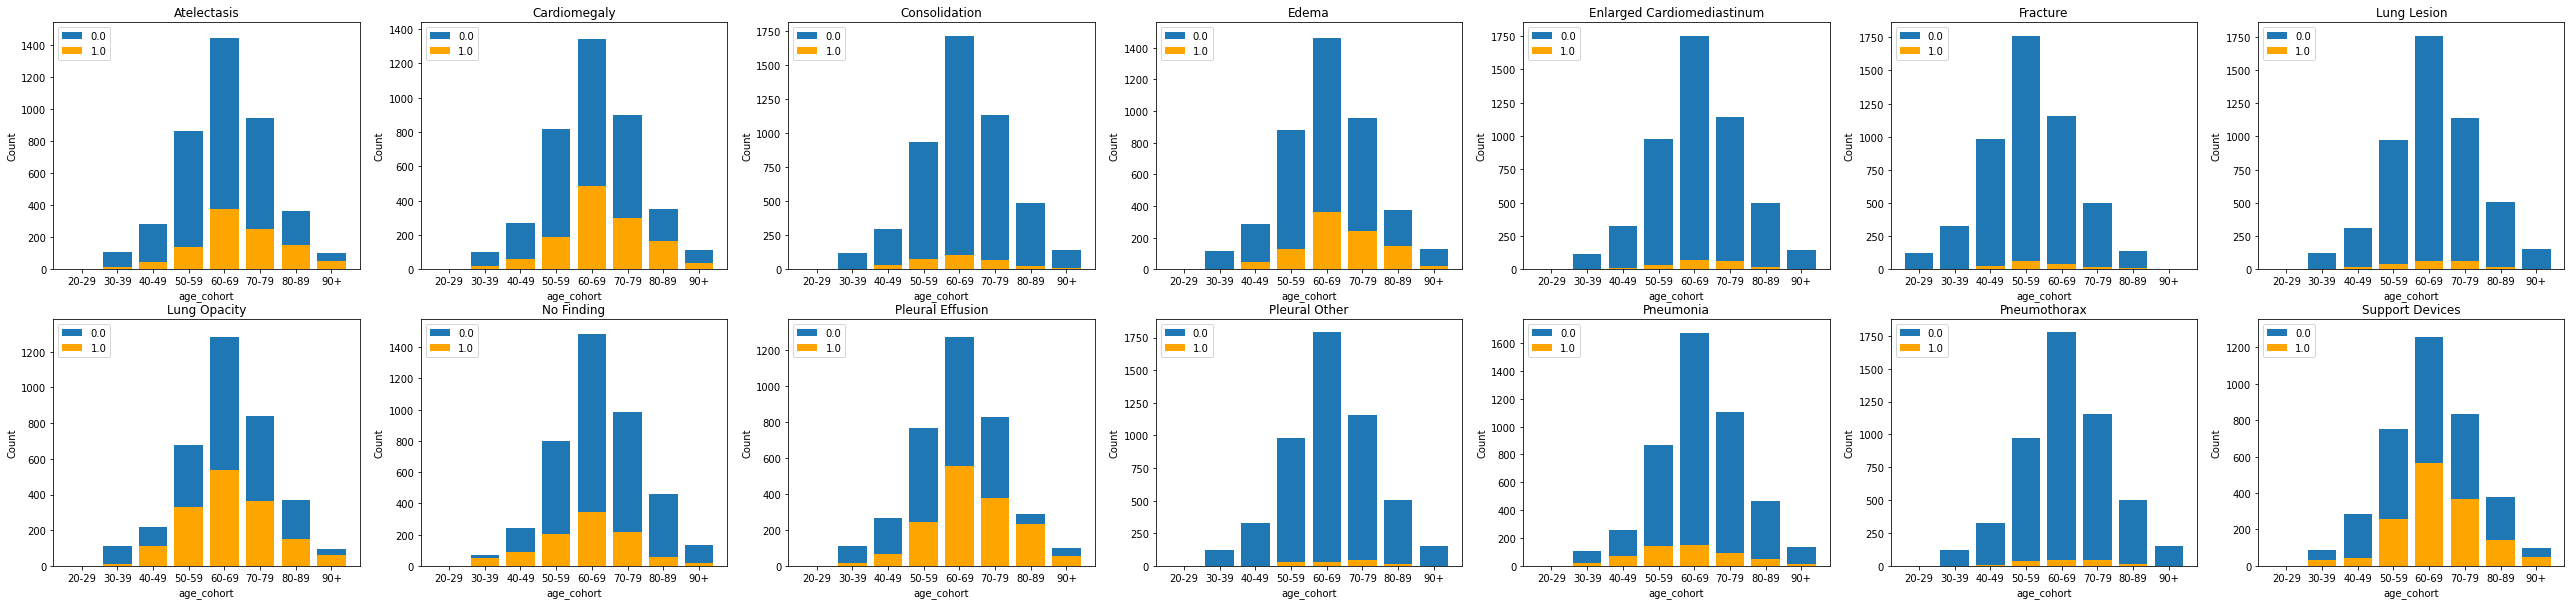

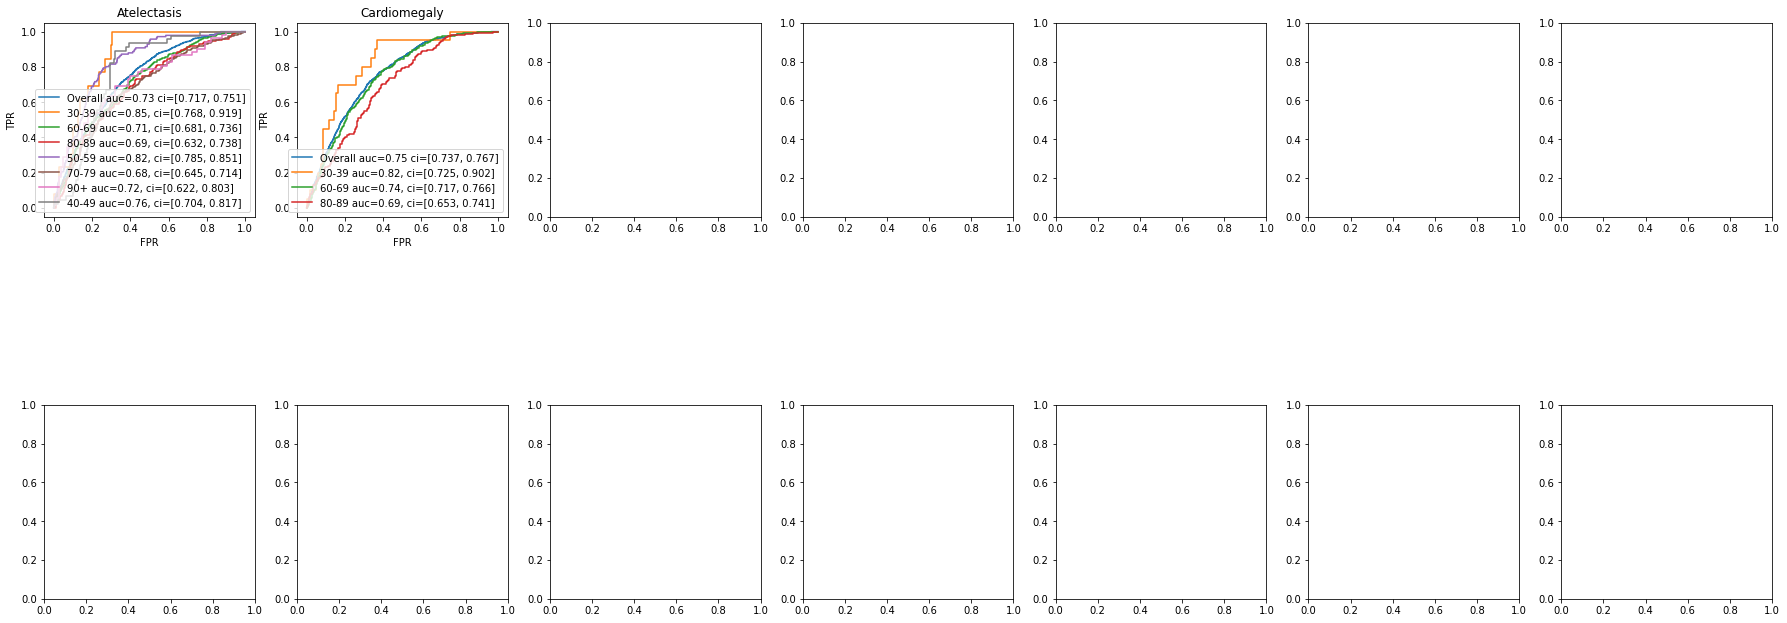

In [43]:
if __name__ == '__main__':
    config = json.load(open('config.json', 'r'))
    labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')
    baseline_dest = config['BASELINE_DEST']
    baseline_results = config['BASELINE_RESULTS_PATH']
    focal_dest = config['FOCAL_DEST']
    focal_results = config['FOCAL_RESULTS_PATH']
    cyclical_dest = config['CYCLICAL_DEST']
    cyclical_results = config['CYCLICAL_RESULTS_PATH']
    
    results_baseline = pd.read_csv(os.path.join(baseline_results, 'results.csv'))
    # Filter out laterals from baseline.
    focal_did = results_focal['dicom_id'].unique()
    results_baseline = results_baseline[results_baseline['dicom_id'].isin(focal_did)].reset_index(drop=True)

    results_focal = pd.read_csv(os.path.join(focal_results, 'results.csv'))
    result_cyclical = pd.read_csv(os.path.join(cyclical_results, 'results.csv'))
    
    counter = 0
    for df, results_path, dest_path in zip([results_baseline, results_focal, result_cyclical], 
                                [baseline_results, focal_results, cyclical_results],
                                [baseline_dest, focal_dest, cyclical_dest]):

        if counter <= 1:
            counter+=1
            continue
        run_all(df.copy(), config, results_path, dest_path, labels)